In [2]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import LeaveOneOutEncoder

# Import supervised model types here:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# define where to find the data
path = "data/Video_Games_Sales_as_at_22_Dec_2016.csv"

<IPython.core.display.Javascript object>

In [4]:
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

## Data From: Kaggle:
## Video Game Sales and Ratings
### Video game sales data from VGChartz with corresponding ratings from Metacritic
### Kendall Gillies,  Rush Kirubi

In [242]:
df = pd.read_csv(path)  # move data into a pandas dataframe
df.head()  # preview the top five rows

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

* Observe percentage of missing data per column.
* Drop rows with missing values.

In [243]:
df.isna().mean().sort_values(ascending=False)

User_Count         0.546025
User_Score         0.546025
Critic_Count       0.513308
Critic_Score       0.513308
Rating             0.404869
Developer          0.396136
Year_of_Release    0.016089
Publisher          0.003230
Genre              0.000120
Name               0.000120
Global_Sales       0.000000
Other_Sales        0.000000
JP_Sales           0.000000
EU_Sales           0.000000
NA_Sales           0.000000
Platform           0.000000
dtype: float64

<IPython.core.display.Javascript object>

Since only data entries with accompanying critic and user scores, will be used in the model the rest of data will be dropped

In [244]:
df = df.dropna(axis=0)

<IPython.core.display.Javascript object>

In [245]:
df = df.astype({"Year_of_Release": "int64"})

<IPython.core.display.Javascript object>

Splitting the data to observe differences in predicting "Global_Sales" vs "NA_Sales". make smaller dataframe for pairplot

In [246]:
df = df.assign(log_NA_Sales=np.log1p(df.NA_Sales))
df = df.assign(log_Global_Sales=np.log1p(df.Global_Sales))

<IPython.core.display.Javascript object>

* Feature engineering. 
* * Seeing how weighing the critic and user scores by their counts will act on the model 

In [247]:
df["Critic_Combo"] = df["Critic_Count"] * df["Critic_Score"]
df["User_Combo"] = df["User_Count"] * df["User_Score"]

<IPython.core.display.Javascript object>

In [248]:
df_NA = df.drop(
    columns=["log_Global_Sales", "Global_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
)
df_Global = df.drop(
    columns=["log_NA_Sales", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
)

<IPython.core.display.Javascript object>

In [249]:
df_NA_num = df_NA.select_dtypes(include=["float64", "int64"])
df_Global_num = df_Global.select_dtypes(include=["float64", "int64"])

<IPython.core.display.Javascript object>

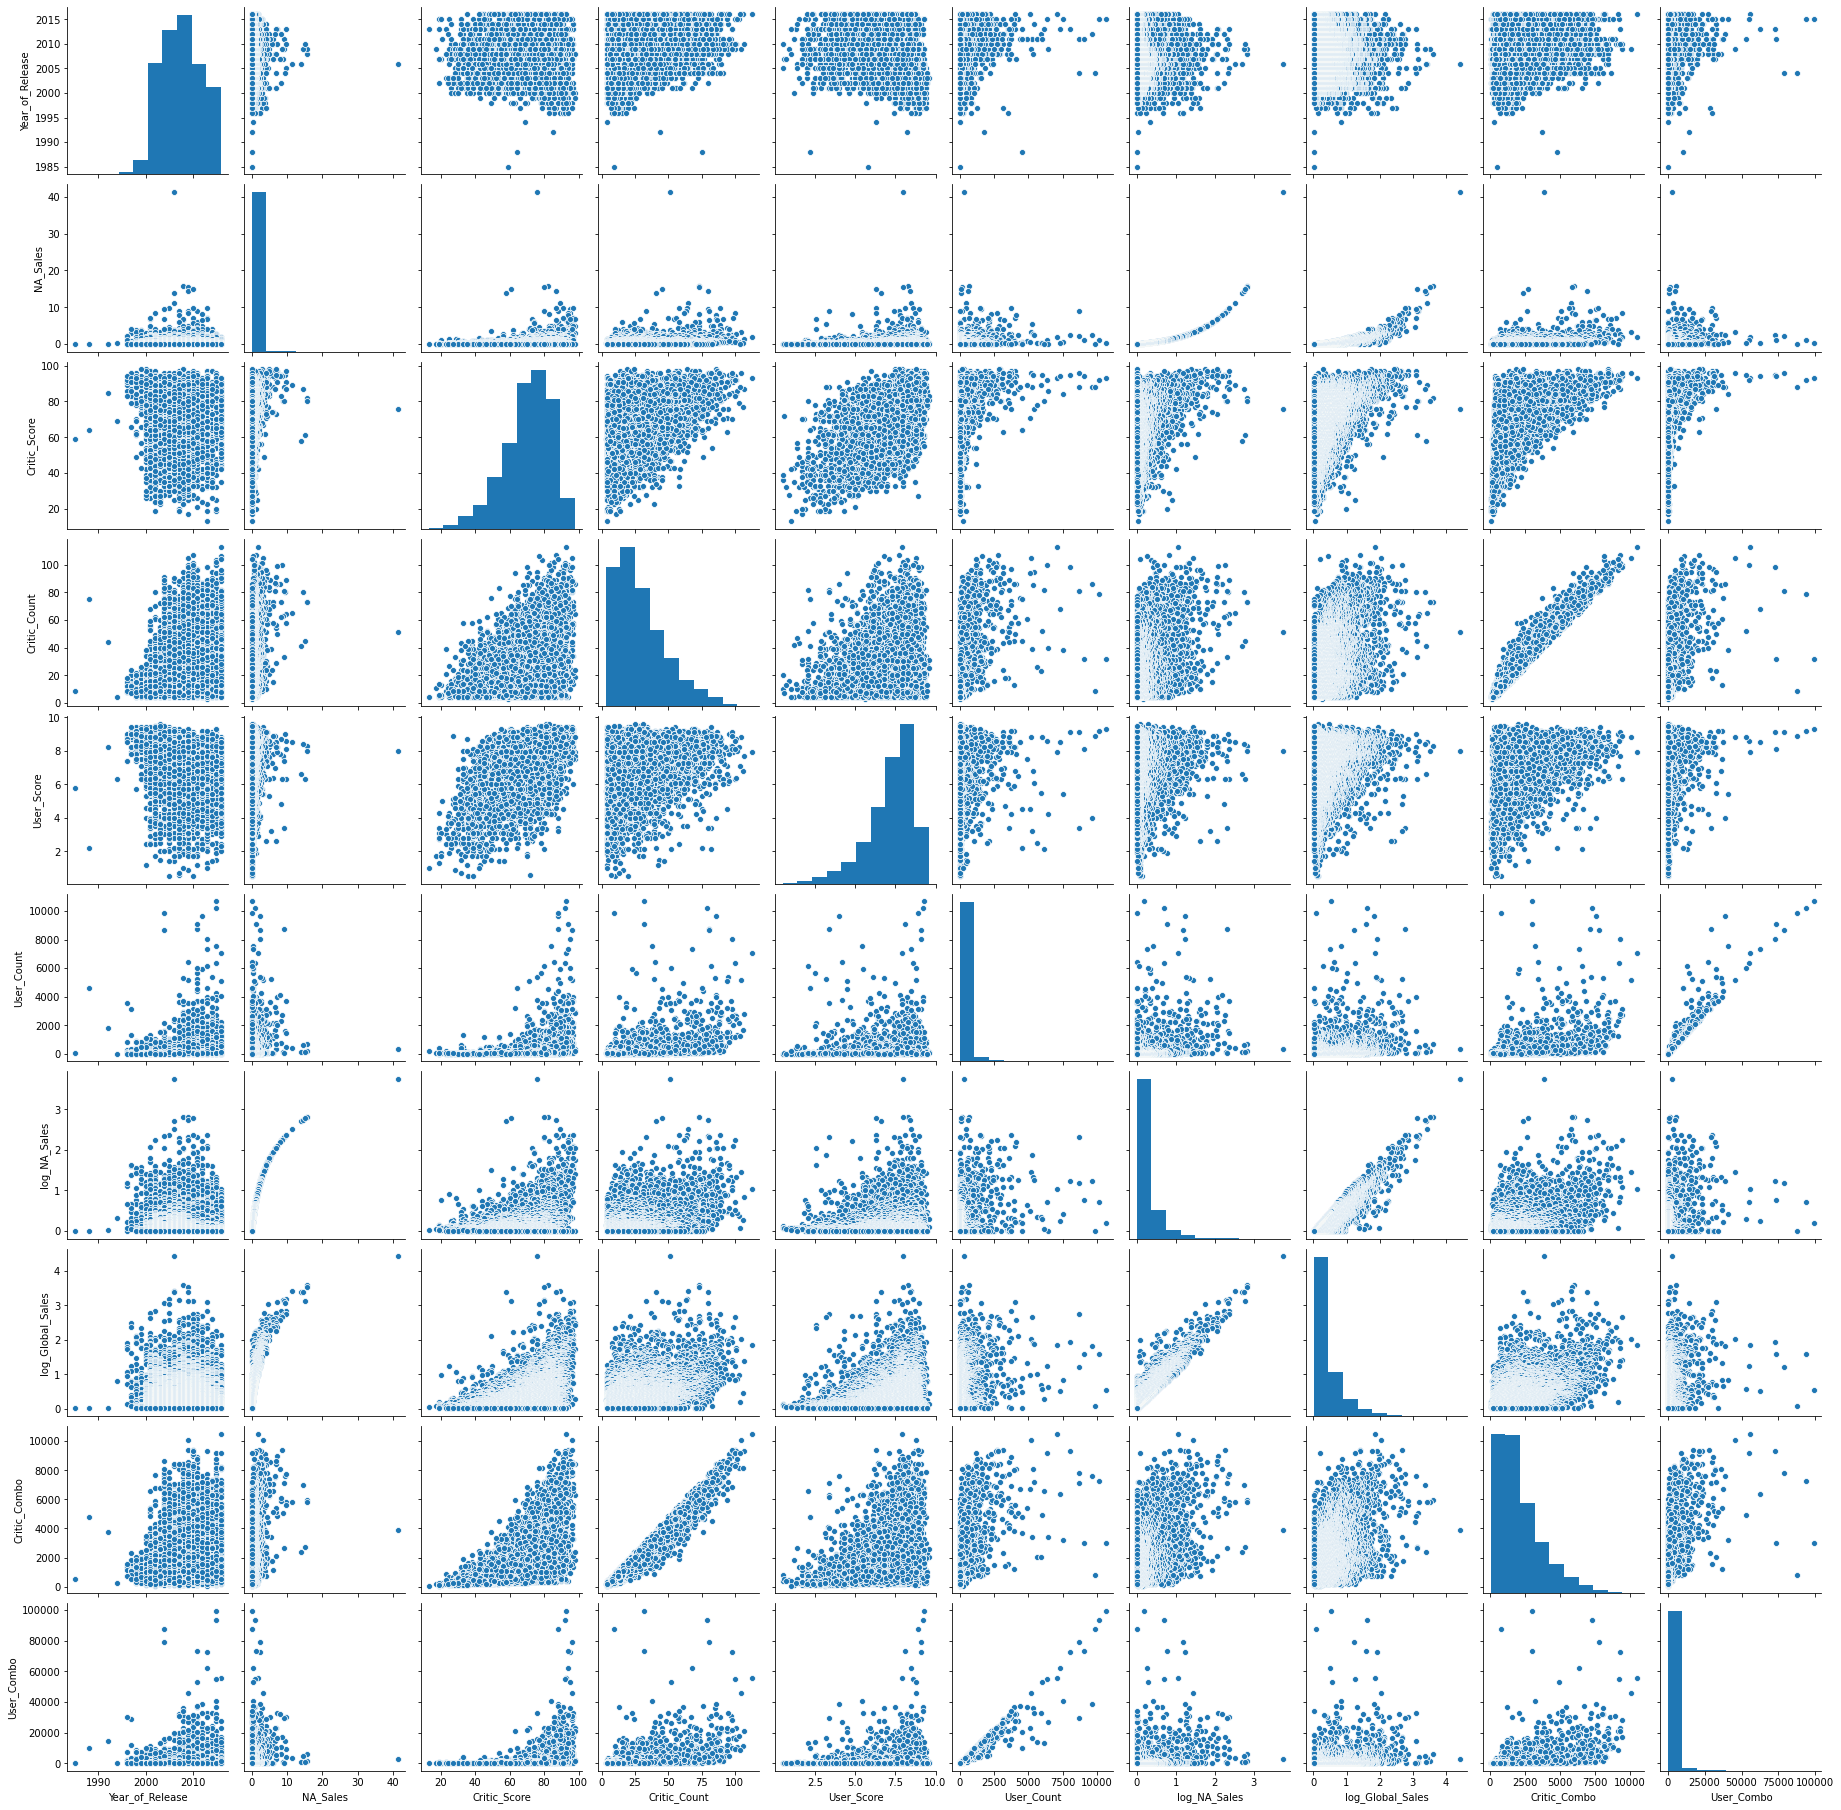

<IPython.core.display.Javascript object>

In [43]:
sns.pairplot(data=df_NA)
plt.show()

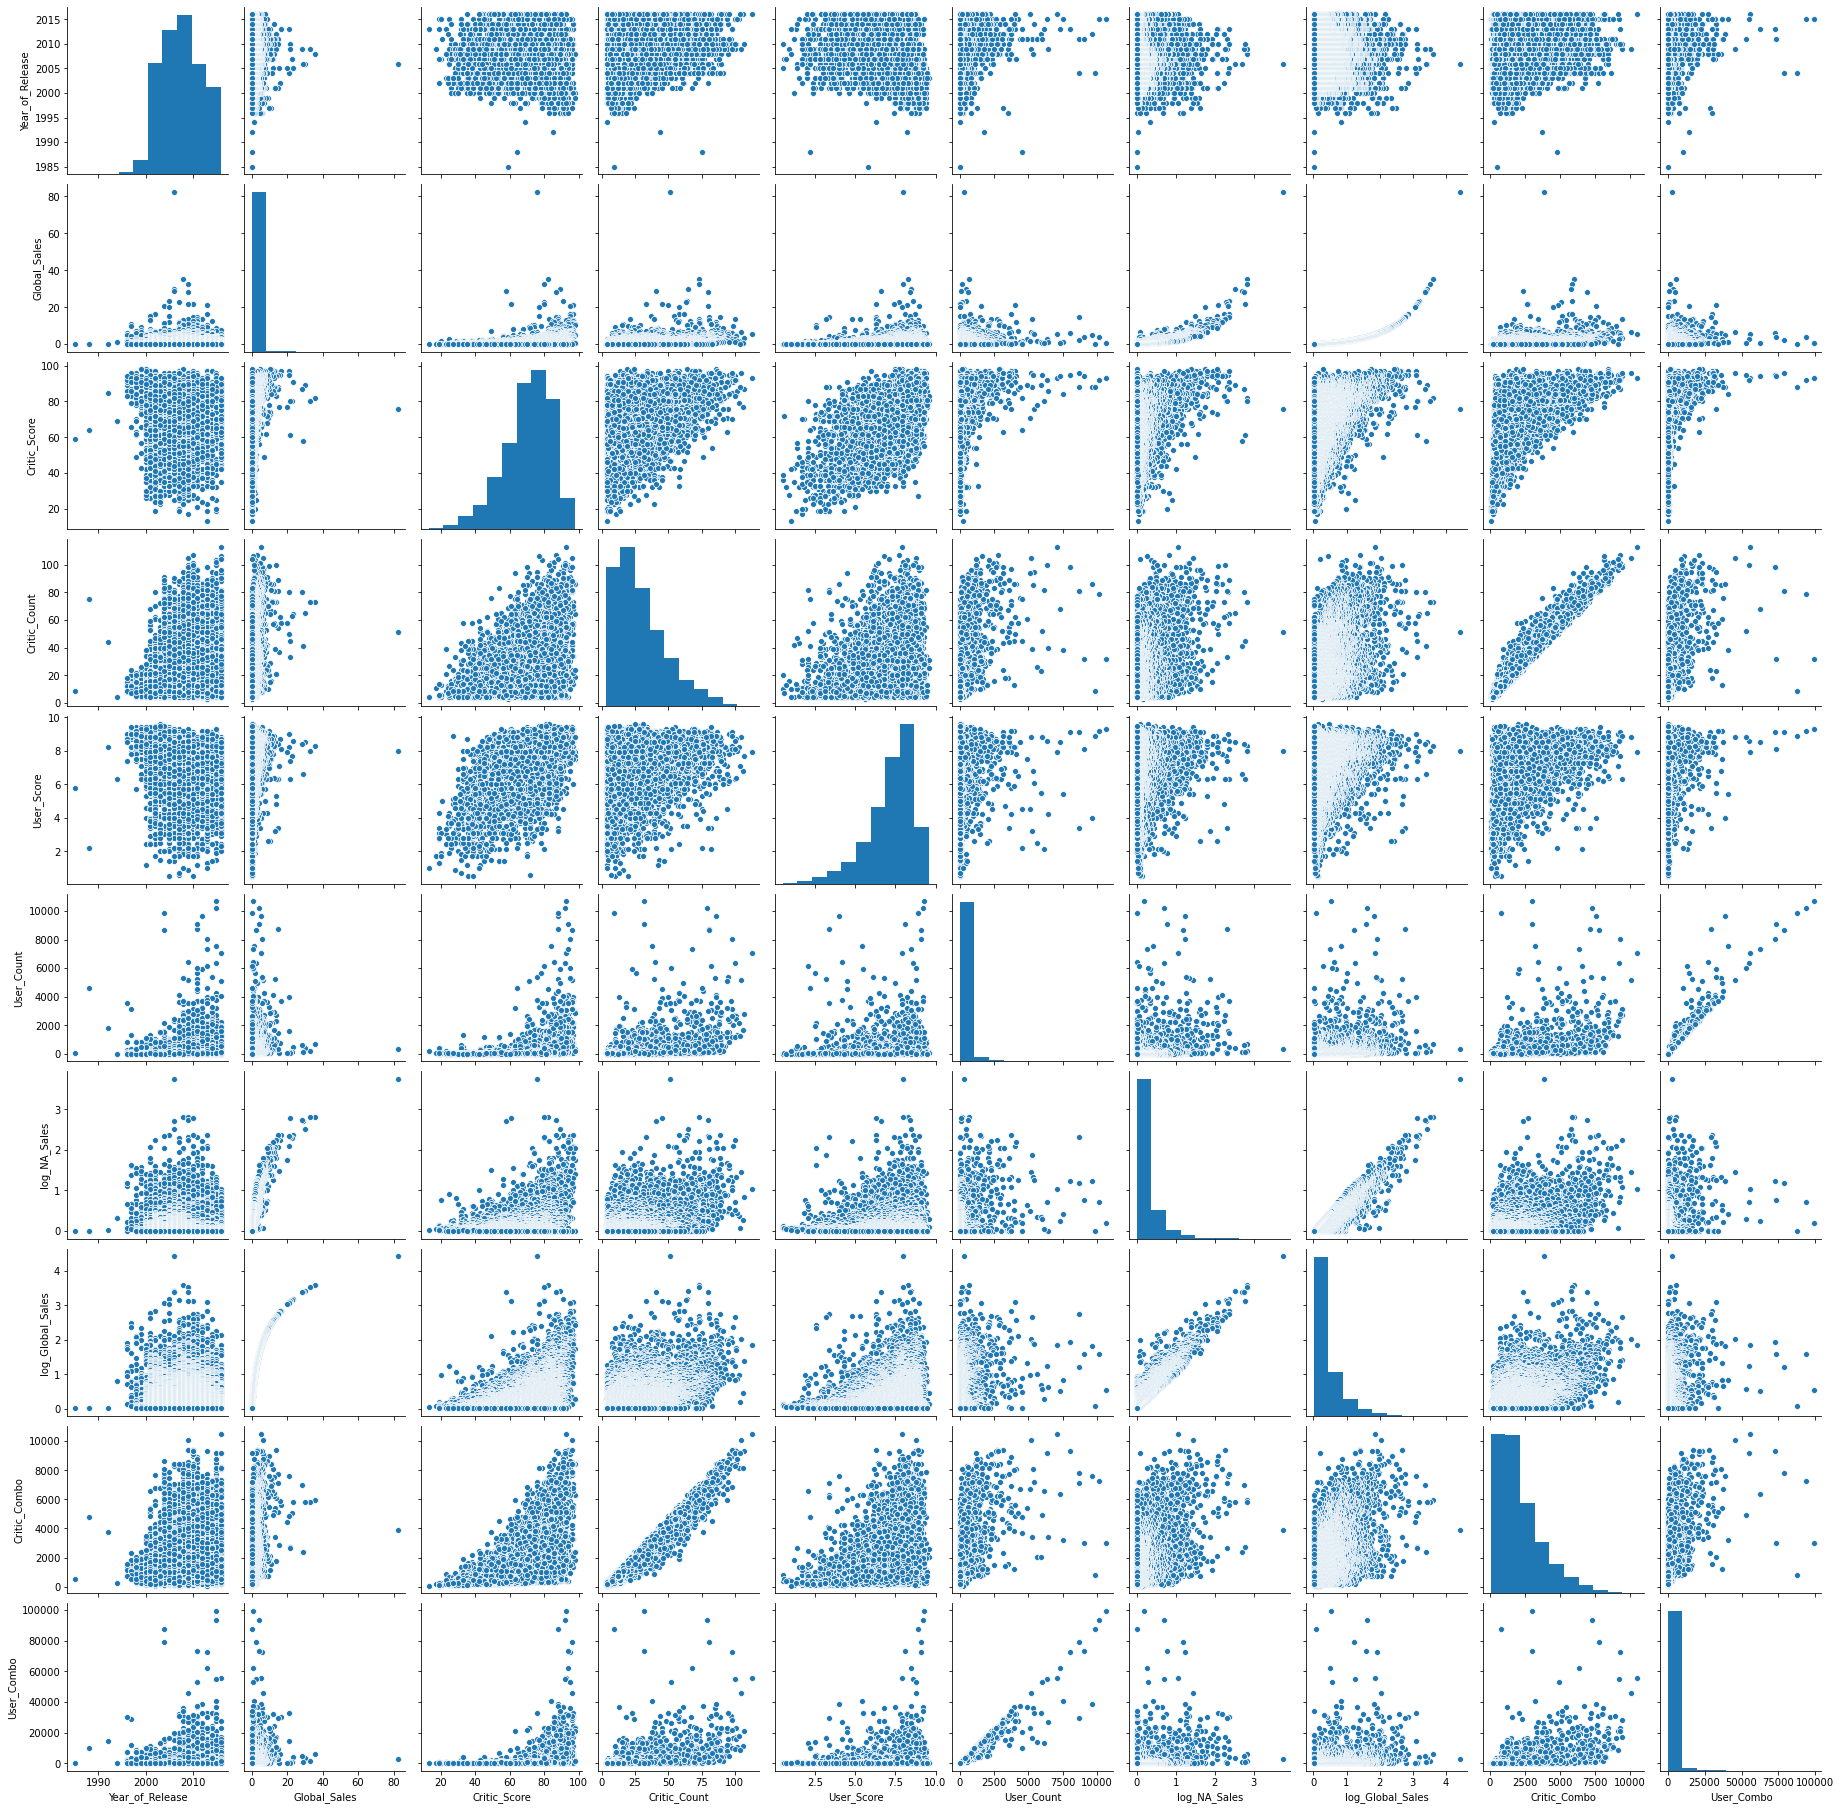

<IPython.core.display.Javascript object>

In [44]:
sns.pairplot(data=df_Global)
plt.show()

Correlations on the log values are a little easier to visualize now.

In [250]:
df_NA_num.columns

Index(['Year_of_Release', 'NA_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'log_NA_Sales', 'Critic_Combo',
       'User_Combo'],
      dtype='object')

<IPython.core.display.Javascript object>

In [251]:
df_NA_num_corr = df_NA_num.corr()["log_NA_Sales"][:]
golden_feature_list = df_NA_num_corr[abs(df_NA_num_corr) > 0.1].sort_values(
    ascending=False
)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 8 strongly correlated values with a column:
log_NA_Sales    1.000000
NA_Sales        0.832614
Critic_Combo    0.449285
Critic_Count    0.391210
Critic_Score    0.344018
User_Count      0.286709
User_Combo      0.284261
User_Score      0.135124
Name: log_NA_Sales, dtype: float64


<IPython.core.display.Javascript object>

Here, it looks like the User_Count is more important that the actual User_Score. 

In [252]:
df_Global_num_corr = df_Global_num.corr()["log_Global_Sales"][:]  # -1 if 'a column'
golden_feature_list = df_Global_num_corr[abs(df_Global_num_corr) > 0.1].sort_values(
    ascending=False
)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 8 strongly correlated values with a column:
log_Global_Sales    1.000000
Global_Sales        0.783157
Critic_Combo        0.492343
Critic_Count        0.434604
Critic_Score        0.381688
User_Count          0.330166
User_Combo          0.325388
User_Score          0.152417
Name: log_Global_Sales, dtype: float64


<IPython.core.display.Javascript object>

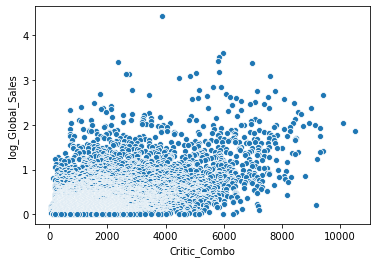

<IPython.core.display.Javascript object>

In [27]:
sns.scatterplot(x=df["Critic_Combo"], y=df["log_Global_Sales"])
plt.show()

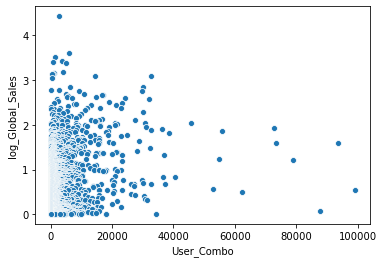

<IPython.core.display.Javascript object>

In [28]:
sns.scatterplot(x=df["User_Combo"], y=df["log_Global_Sales"])
plt.show()

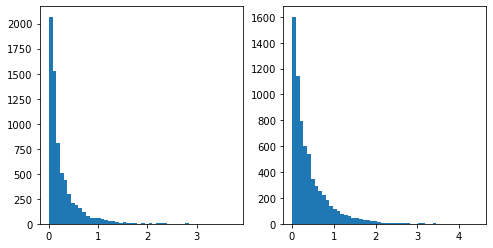

<IPython.core.display.Javascript object>

In [57]:
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.hist(x=df["log_NA_Sales"], bins=50)
plt.subplot(122)
plt.hist(x=df["log_Global_Sales"], bins=50)
plt.show()


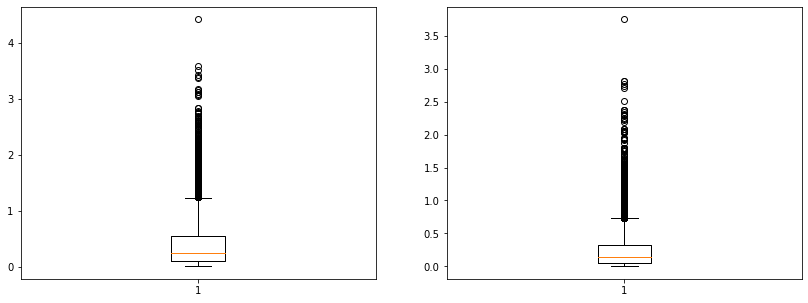

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.boxplot(np.log1p(df["Global_Sales"]))
plt.subplot(122)
plt.boxplot(np.log1p(df["NA_Sales"]))

plt.show()

Some of the 'Rating' catagory have too few entries. They will be dropped.

In [253]:
wantedRatings = (
    (df.Rating == "E") | (df.Rating == "M") | (df.Rating == "T") | (df.Rating == "E10+")
)
df = df.iloc[wantedRatings.values]

<IPython.core.display.Javascript object>

Next the outliers will be dropped to help improve performace.

In [254]:
df["Global_Sales"].describe()

count    6822.000000
mean        0.777360
std         1.963754
min         0.010000
25%         0.110000
50%         0.290000
75%         0.750000
max        82.530000
Name: Global_Sales, dtype: float64

<IPython.core.display.Javascript object>

In [60]:
perc_90, perc_95, perc_97, perc_99 = np.percentile(df["Global_Sales"], [90, 95, 97, 99])
print(perc_90, perc_95, perc_97, perc_99)

1.7 2.899499999999998 3.9958999999999927 7.1678999999999995


<IPython.core.display.Javascript object>

In [95]:
in_perc_90 = df.Global_Sales <= perc_90
in_perc_95 = df.Global_Sales <= perc_95
in_perc_97 = df.Global_Sales <= perc_97
in_perc_99 = df.Global_Sales <= perc_99

df_90_G = df.iloc[in_perc_90.values]
df_95_G = df.iloc[in_perc_95.values]
df_97_G = df.iloc[in_perc_97.values]
df_99_G = df.iloc[in_perc_99.values]


<IPython.core.display.Javascript object>

In [96]:
perc_90, perc_95, perc_97, perc_99 = np.percentile(df["NA_Sales"], [90, 95, 97, 99])

in_perc_90 = df.NA_Sales <= perc_90
in_perc_95 = df.NA_Sales <= perc_95
in_perc_97 = df.NA_Sales <= perc_97
in_perc_99 = df.NA_Sales <= perc_99

df_90 = df.iloc[in_perc_90.values]
df_95 = df.iloc[in_perc_95.values]
df_97 = df.iloc[in_perc_97.values]
df_99 = df.iloc[in_perc_99.values]


<IPython.core.display.Javascript object>

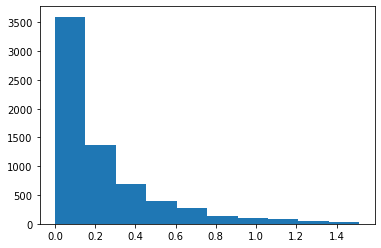

<IPython.core.display.Javascript object>

In [63]:
plt.hist(x=df_99["log_NA_Sales"])
plt.show()

In [64]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating',
       'log_NA_Sales', 'log_Global_Sales', 'Critic_Combo', 'User_Combo'],
      dtype='object')

<IPython.core.display.Javascript object>

Here it is decided to drop out some colummns that are going to cause problems or be multilcolinear. 
It is safe to say that sales in other places will definitely be removed. Keeping them in would be cheating. and log_Global_Sales will be the target variable.

In [255]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

<IPython.core.display.Javascript object>

In [256]:
df_Global_num = df_Global.select_dtypes(include=["float64", "int64"])
df_Global_num = df_Global_num.drop(
    columns=[
        "Global_Sales",
        "log_Global_Sales",
        "User_Score",
        "User_Combo",
        "Critic_Count",
        "Critic_Score",
    ]
)

<IPython.core.display.Javascript object>

In [257]:
calc_vif(df_Global_num)

,variables,VIF
0,Year_of_Release,2.775790
1,User_Count,1.316186
2,Critic_Combo,3.268180


<IPython.core.display.Javascript object>

Some of the numeric columns where dropped due to multicolinearity

In [258]:
df_cats = df.select_dtypes(include=["object"])

<IPython.core.display.Javascript object>

In [259]:
df_cats.columns

Index(['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating'], dtype='object')

<IPython.core.display.Javascript object>

In [260]:
df_cats.Publisher.unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'SquareSoft',
       'GT Interactive', 'Konami Digital Entertainment', 'Square Enix',
       'Sony Computer Entertainment Europe', 'Virgin Interactive',
       'LucasArts', '505 Games', 'Capcom',
       'Warner Bros. Interactive Entertainment', 'Universal Interactive',
       'RedOctane', 'Atari', 'Eidos Interactive', 'Namco Bandai Games',
       'Vivendi Games', 'MTV Games', 'Sega', 'THQ',
       'Disney Interactive Studios', 'Acclaim Entertainment',
       'Midway Games', 'Deep Silver', 'NCSoft', 'Tecmo Koei',
       'Valve Software', 'Infogrames', 'Mindscape', 'Valve',
       'Hello Games', 'Global Star', 'Gotham Games',
       'Crave Entertainment', 'Hasbro Interactive', 'Codemasters',
       'TDK Mediactive', 'Zoo Games', 'Sony Oznline Entertainment', 'RTL',
       'D3Publisher', 'Black Label Games', 'So

<IPython.core.display.Javascript object>

In [196]:
df_cats.Platform.value_counts()

PS2     1140
X360     858
PS3      769
PC       650
XB       564
Wii      479
DS       464
PSP      390
GC       348
PS4      239
GBA      237
XOne     159
3DS      155
PS       149
PSV      118
WiiU      89
DC        14
Name: Platform, dtype: int64

<IPython.core.display.Javascript object>

In [197]:
df_cats.Genre.value_counts()

Action          1629
Sports           943
Shooter          864
Role-Playing     712
Racing           581
Platform         403
Misc             383
Fighting         378
Simulation       297
Strategy         266
Adventure        248
Puzzle           118
Name: Genre, dtype: int64

<IPython.core.display.Javascript object>

In [261]:
df.Publisher.value_counts()

Electronic Arts                944
Ubisoft                        496
Activision                     492
Sony Computer Entertainment    315
THQ                            307
                              ... 
EA Games                         1
Alternative Software             1
ASCII Entertainment              1
HMH Interactive                  1
Russel                           1
Name: Publisher, Length: 263, dtype: int64

<IPython.core.display.Javascript object>

In [232]:
other_list

['505 Games',
 'Deep Silver',
 'Disney Interactive Studios',
 'LucasArts',
 'Acclaim Entertainment',
 'Nippon Ichi Software',
 'Rising Star Games',
 'Bethesda Softworks',
 'D3Publisher',
 'Focus Home Interactive',
 'Ignition Entertainment',
 'Empire Interactive',
 'Atlus',
 'Unknown',
 'Zoo Digital Publishing',
 'Majesco Entertainment',
 'PQube',
 'Kalypso Media',
 'TDK Mediactive',
 'SouthPeak Games',
 'Global Star',
 'Virgin Interactive',
 'Universal Interactive',
 'MTV Games',
 '3DO',
 'Infogrames',
 'Paradox Interactive',
 'DTP Entertainment',
 'Ubisoft Annecy',
 'SCi',
 'Sony Computer Entertainment Europe',
 'Crave Entertainment',
 'Nordic Games',
 'Playlogic Game Factory',
 'JoWood Productions',
 'BAM! Entertainment',
 'Play It',
 'Ghostlight',
 'SquareSoft',
 'Marvelous Interactive',
 'City Interactive',
 'Interplay',
 'Gathering of Developers',
 'Spike',
 'Metro 3D',
 'Idea Factory',
 'Midas Interactive Entertainment',
 'Microids',
 'Jaleco',
 'Black Bean Games',
 'Kemco',
 'Po

<IPython.core.display.Javascript object>

In [263]:
other_list = []
for i in range(df_cats.Publisher.nunique()):
    if df_cats['Publisher'].value_counts()[i] <=100:
        other_list.append(df_cats.Publisher.value_counts().index[i])


<IPython.core.display.Javascript object>

In [264]:
df.loc[df["Publisher"].isin(other_list), "Publisher"] = "Other"

<IPython.core.display.Javascript object>

In [265]:
df["Publisher"].nunique()

21

<IPython.core.display.Javascript object>

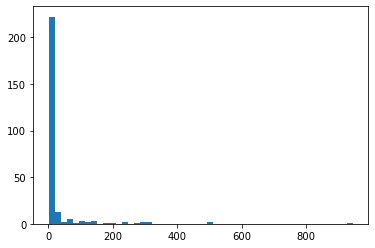

<IPython.core.display.Javascript object>

In [202]:
plt.hist(df_cats.Publisher.value_counts(), bins=50)
plt.show()

In [268]:
df.Publisher.value_counts()

Other                                     1573
Electronic Arts                            944
Ubisoft                                    496
Activision                                 492
Sony Computer Entertainment                315
THQ                                        307
Nintendo                                   291
Sega                                       284
Take-Two Interactive                       272
Konami Digital Entertainment               244
Namco Bandai Games                         239
Capcom                                     197
Atari                                      176
Microsoft Game Studios                     141
Tecmo Koei                                 137
Square Enix                                134
Warner Bros. Interactive Entertainment     130
Eidos Interactive                          123
Vivendi Games                              113
Codemasters                                111
Midway Games                               103
Name: Publish

<IPython.core.display.Javascript object>

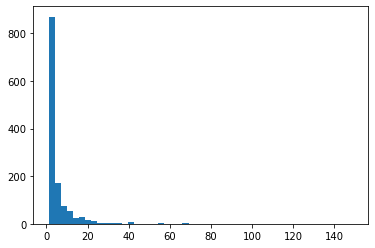

<IPython.core.display.Javascript object>

In [273]:
plt.hist(df.Developer.value_counts(), bins=50)
plt.show()

In [284]:
other_list = []
for i in range(df_cats.Developer.nunique()):
    if df_cats["Developer"].value_counts()[i] <= 50:
        other_list.append(df_cats.Developer.value_counts().index[i])

<IPython.core.display.Javascript object>

In [285]:
df.loc[df["Developer"].isin(other_list), "Developer"] = "Other"

<IPython.core.display.Javascript object>

In [286]:
df.Developer.value_counts()

Other                5538
EA Canada             149
EA Sports             142
Capcom                126
Ubisoft               103
Konami                 95
Ubisoft Montreal       87
EA Tiburon             82
Omega Force            69
Nintendo               68
Visual Concepts        68
Electronic Arts        67
Traveller's Tales      59
Vicarious Visions      57
Codemasters            57
Namco                  55
Name: Developer, dtype: int64

<IPython.core.display.Javascript object>

In [287]:
drop_cols = [
    "Name",
    "NA_Sales",
    "Global_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
    #    "Publisher",
    #     "Developer",
    "log_Global_Sales",
    "log_NA_Sales",
    "User_Score",
    #     "User_Count",
    "User_Combo",
    "Critic_Count",
    "Critic_Score",
    #     "Critic_Combo",
]

X = df.drop(columns=drop_cols)
y = df["log_Global_Sales"]

<IPython.core.display.Javascript object>

In [288]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X.Rating
)

<IPython.core.display.Javascript object>

In [289]:
num_cols = [
    "Year_of_Release",
    "User_Count",
    #     "User_Score",
    #     "User_Combo",
    #     "Critic_Count",
    #     "Critic_Score",
    "Critic_Combo",
]
bin_cols = []
cat_cols = ["Platform", "Genre", "Rating", "Publisher", "Developer"]
drop_cats = ["PS4", "Sports", "E", "Other", "Other"]

<IPython.core.display.Javascript object>

## XGBoost Regression Model

In [290]:
# fmt: off
preprocessing = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
], remainder="passthrough")

<IPython.core.display.Javascript object>

In [296]:
# fmt: off
params = {
#     "model__subsample": [ 0.65, 0.75, .8, 1],
    "model__subsample": [0.25, 0.5, 0.75, 1.0],
#     "model__colsample_bytree": [ 0.75, 0.85, .90, 1],
    "model__colsample_bytree": [0.25 , 0.5,  1.0],
#     "model__max_depth": [7, 8, 9, 10],
    "model__max_depth": [12, 14, 16],
}
n_trees = 100
learning_rate = 2 / n_trees

<IPython.core.display.Javascript object>

In [292]:
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", XGBRegressor(n_estimators=n_trees, learning_rate=learning_rate)),
    ]
)

<IPython.core.display.Javascript object>

In [293]:
pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

<IPython.core.display.Javascript object>

In [297]:
pipeline_cv.fit(X_train, y_train)

print(f"Train Score: {pipeline_cv.score(X_train, y_train)}")
print(f"Test Score: {pipeline_cv.score(X_test, y_test)}")

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   58.7s finished


Train Score: 0.8371430643582177
Test Score: 0.5866278893662664


<IPython.core.display.Javascript object>

* There is no real difference in the predicting 'NA_Sales' vs 'Global_Sales'.
* Removing outliers in the Sales data only hurt the model.


99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': 1,'model__max_depth': 10,'model__subsample': 0.75}
Train Score: 0.7091890031893382
Test Score: 0.5005489069929983

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': .85,'model__max_depth': 9,'model__subsample': 0.75}
Train Score: 0.6709216221163665
Test Score: 0.5014700261290725

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': .85,'model__max_depth': 8,'model__subsample': 0.75}
Train Score: 0.6343650050335347
Test Score: 0.5011677336836367

100 percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': 1.0,'model__max_depth': 10,'model__subsample': 0.6}
Train Score: 0.7917334440524151
Test Score: 0.5429274948210776



In [298]:
pipeline_cv.best_params_

{'model__colsample_bytree': 1.0,
 'model__max_depth': 14,
 'model__subsample': 0.5}

<IPython.core.display.Javascript object>

In [300]:
y_pred = pipeline_cv.predict(X_test)
y_pred_exp = np.exp(y_pred)-1
y_test_exp = np.exp(y_test)-1
MAE = np.mean(abs(y_test_exp-y_pred_exp))
MAPE = np.mean(abs((y_test_exp-y_pred_exp)/y_test_exp))
print(MAE)
print(MAPE)


0.43715329938406555
1.9332215490946163


<IPython.core.display.Javascript object>

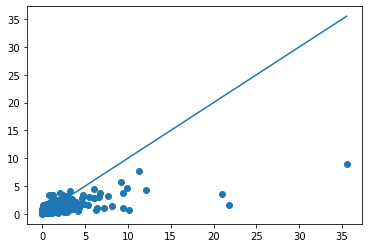

<IPython.core.display.Javascript object>

In [301]:
plt.scatter(y_test_exp, y_pred_exp)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()])
plt.show()

## Lasso Model

In [302]:
preprocessing.fit(X_train)

X_train_trans = preprocessing.transform(X_train)
X_test_trans = preprocessing.transform(X_test)

<IPython.core.display.Javascript object>

In [303]:
grid = {"alpha": [0.00000001, 0.0000001, 0.000001, 0.00001]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5, n_jobs=-1)
lasso_cv.fit(X_train_trans, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.8s finished


selected alpha: 1e-05


array([-0.03250815,  0.10593282,  0.18275342, -0.05495202, -0.06877049,
        0.04083463, -0.07169914, -0.14417464, -0.31566995,  0.31541731,
        0.10872636,  0.09295422, -0.00949021, -0.05576368,  0.12508215,
       -0.18612484, -0.01877406, -0.16387633,  0.05187026,  0.00384827,
       -0.1009443 ,  0.04039644,  0.07823943,  0.03982065, -0.12170222,
        0.02747272, -0.02877903,  0.01507939,  0.08957246, -0.10222822,
       -0.08747452, -0.05786809, -0.08323969,  0.17445226,  0.03969751,
       -0.11185617, -0.06946377, -0.04065175,  0.19791504, -0.01770384,
        0.1488108 , -0.02099083, -0.02763113,  0.27788596,  0.01743585,
        0.02864541,  0.11727267,  0.07478283,  0.13674299, -0.14371628,
        0.04597575, -0.02009095,  0.25316149,  0.18605941,  0.02599349,
       -0.05589724,  0.04887702,  0.06765583, -0.02070732,  0.07509834,
        0.10263895,  0.74290311,  0.1782674 ,  0.33476006,  0.166828  ,
        0.18944035,  0.12670142,  0.15921718])

<IPython.core.display.Javascript object>

In [304]:
print(f"Train Score: {lasso_cv.score(X_train_trans, y_train)}")
print(f"Test Score: {lasso_cv.score(X_test_trans, y_test)}")

Train Score: 0.47961780911208274
Test Score: 0.4161887635151823


<IPython.core.display.Javascript object>

In [305]:
y_pred = lasso_cv.predict(X_test_trans)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.5076460519510476
0.23621165346085668


<IPython.core.display.Javascript object>

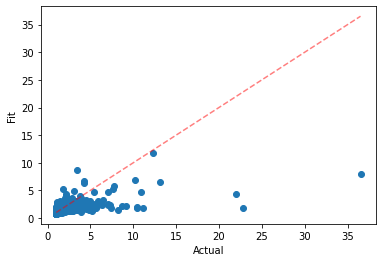

<IPython.core.display.Javascript object>

In [306]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

## Elastic Net Model

In [307]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1], "l1_ratio": [0.1, 0.5, 0.75, 1]}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train_trans, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   11.4s finished


selected alpha: 0.001
selected l1_ratio: 0.1


array([-0.0328421 ,  0.10559881,  0.18521781, -0.03656365, -0.00433893,
        0.04785102, -0.05168946, -0.1262427 , -0.30028405,  0.31196527,
        0.11715322,  0.10139409, -0.        , -0.03963862,  0.13282483,
       -0.14747623, -0.00716698, -0.1497716 ,  0.06076788,  0.        ,
       -0.10268494,  0.03182735,  0.07079643,  0.03149986, -0.11619273,
        0.01910195, -0.03714329,  0.00772805,  0.07793991, -0.10818424,
       -0.08233819, -0.05988939, -0.08363841,  0.16545909,  0.02686872,
       -0.09766623, -0.0546107 , -0.0407771 ,  0.18682721, -0.01309858,
        0.12694734, -0.02268963, -0.02674823,  0.27458532,  0.00552152,
        0.02032656,  0.09997618,  0.06402195,  0.12566344, -0.12390496,
        0.04616919, -0.01996102,  0.22955404,  0.15541556,  0.        ,
       -0.05140932,  0.0421281 ,  0.05412531, -0.01005005,  0.0510431 ,
        0.07894725,  0.65906995,  0.13389394,  0.28784736,  0.14275607,
        0.16097807,  0.09763754,  0.13491874])

<IPython.core.display.Javascript object>

In [308]:
print(f"Train Score: {elasticnet_cv.score(X_train_trans, y_train)}")
print(f"Test Score: {elasticnet_cv.score(X_test_trans, y_test)}")



Train Score: 0.4786152326828036
Test Score: 0.42011773855147105


<IPython.core.display.Javascript object>

In [309]:
y_pred = elasticnet_cv.predict(X_test_trans)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.5063829443533414
0.23400181930417518


<IPython.core.display.Javascript object>

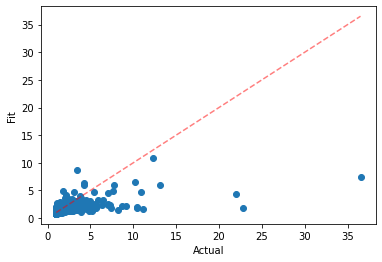

<IPython.core.display.Javascript object>

In [310]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

## KNN model

In [311]:
pipeline = Pipeline([("preprocessing", preprocessing), ("knn", KNeighborsRegressor())])

<IPython.core.display.Javascript object>

In [312]:
ks = np.arange(1, 100, 2)
rmses = []

for k in ks:
    pipeline.named_steps["knn"].n_neighbors = k
    neg_rmses = cross_val_score(
        pipeline, X_train, y_train, scoring="neg_root_mean_squared_error"
    )
    avg_rmse = np.mean(-neg_rmses)
    rmses.append(avg_rmse)

<IPython.core.display.Javascript object>

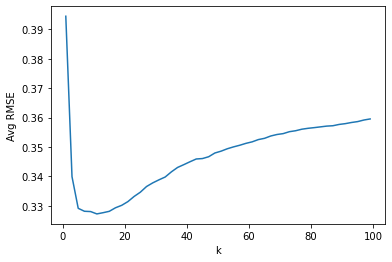

<IPython.core.display.Javascript object>

In [313]:
plt.plot(ks, rmses)
plt.xlabel("k")
plt.ylabel("Avg RMSE")
plt.show()

In [314]:
grid = {"knn__n_neighbors": np.arange(1, 100, 4)}
model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

model.best_params_

{'knn__n_neighbors': 13}

<IPython.core.display.Javascript object>

In [315]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.5831273952438252
0.47687965993626025


<IPython.core.display.Javascript object>

In [316]:
y_pred = model.predict(X_test)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.4735418978867178
0.20736907066417257


<IPython.core.display.Javascript object>

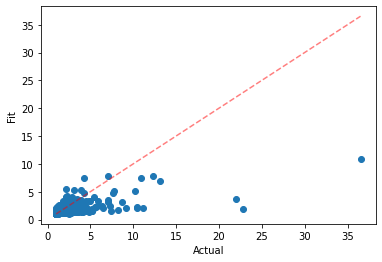

<IPython.core.display.Javascript object>

In [317]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()